# Data processing: data collection, data pre-processing, data modelling, data analysis

In [2]:
# %pip install pandas
# %pip install requests
# %pip install bs4
# %pip install lxml

# %pip install spacy
# !python -m spacy download en_core_web_md
# !python -m spacy download en
# %pip install gensim

# Importing packages for supporting manipulating data

In [3]:
# Data collection
import pandas as pd     # working with relational or labeled data easily and intuitively.
import csv          # implements classes to read and write tabular data in CSV format.
# warnings
import warnings     # Warnings provided situations that aren’t necessarily exceptions.
from requests.packages.urllib3.exceptions import InsecureRequestWarning
warnings.simplefilter('ignore', InsecureRequestWarning)
import requests     # Requests allows you to send HTTP/1.1 requests extremely easily
from bs4 import BeautifulSoup       #  scrape information from web pages. 
import lxml         # lxml is a Python library which allows for easy handling of XML and HTML files, and can also be used for web scraping.
import urllib3      # urllib3 is a powerful, user-friendly HTTP client for Python

# Data pre-processing
import re           # regular expression matching operations
import spacy
from gensim.corpora.dictionary import Dictionary    # Dictionary encapsulates the mapping between normalized words and their integer ids.

# Data modelling
from gensim.models.tfidfmodel import TfidfModel     # This module implements functionality related to the Term Frequency - Inverse Document Frequency class of bag-of-words vector space models.
from gensim.models.ldamulticore import LdaMulticore     # Online Latent Dirichlet Allocation (LDA) in Python, using all CPU cores to parallelize and speed up model training.
from gensim.models.nmf import Nmf                       # a visual explainer and Python Implementation
from gensim.models.lsimodel import LsiModel             # LSI is an NLP approach that is particularly useful in distributional semantics.

# Data analysis
import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec                      # Word2Vec consists of models for generating word embedding. Word Embedding is a language modeling technique used for mapping words to vectors of real numbers.
from gensim.similarities import WordEmbeddingSimilarityIndex        # A term similarity index that computes cosine similarities between word embeddings.
# SoftCosineSimilarity: to retrieve documents most similar to a query and compare the performance against other similarity measures.
# SparseTermSimilarityMatrix: Compute similarity against a corpus of documents by storing the sparse index matrix in memory. The similarity measure used is cosine between two vectors.
from gensim.similarities import SoftCosineSimilarity, SparseTermSimilarityMatrix    

# Coherence score analysis
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data collection

In [4]:
# getting a two-dimensional dataframe with labeled axes from a comma-sperated values file and indexing each lines

retrievalHistoryReport = pd.read_csv('history.csv', lineterminator='\n', sep=',', header=0, error_bad_lines=False)
retrievalHistoryReport.index = range(len(retrievalHistoryReport))

# read csv file as a two-dimensional list 
csv_reader = csv.reader(open("./history.csv"))
links = []  # the axis of links in dataframe retrievalHistoryReport
for line in csv_reader:
    links.append(line)
links = links[1:]

# approximately scraping text in the links in <p> tags and putting captured text into dataframe retrievalHistoryReport
def getContent(links) -> list:
    content = []
    for link in links:
        r = requests.get(link[0], verify=False)  
        soup = BeautifulSoup(r.text, "lxml")
        oneline=''
        for link in soup.find_all("p"):
            oneline+=link.get_text()
        content.append(oneline)
    return content

content = getContent(links)
retrievalHistoryReport['content'] = content

/var/folders/fc/xgt611892s1d8k4y_6gmdv1c0000gn/T/ipykernel_39034/1492083144.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  retrievalHistoryReport = pd.read_csv('history.csv', lineterminator='\n', sep=',', header=0, error_bad_lines=False)


# Data pre-processing

In [5]:
nlp = spacy.load("en_core_web_md")          # applied English NLP model
nlp.max_length=5563920

# Normalization 
retrievalHistoryReport['content'] = retrievalHistoryReport['content'].astype('str') # transformed data type

def preprocess(text):
    text = re.sub('[!"”$%&’()*+,-./:;<=>?[\\]^_`{|}~@#]','',text)   # Removing special characters 
    text = text.lower()                                             # convert all words to lower case
    return text
retrievalHistoryReport['content'] = retrievalHistoryReport.content.apply(preprocess)

removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']    # remove stopwords, as these do not contribute a lot to the information in the sentences.
tokens = []
for doc in nlp.pipe(retrievalHistoryReport['content']):
    proj_tok = [token.lemma_ for token in doc if token.pos_ not in removal and not token.is_stop]   # lemmanization and removing meaningless words
    tokens.append(proj_tok)
retrievalHistoryReport['tokens'] = tokens       # Normalized data

for doc in range(len(retrievalHistoryReport)):  # 如果token里没有词，就drop掉不参与计算
    if(len(retrievalHistoryReport['tokens'][doc]) < 1):
        retrievalHistoryReport.drop([doc],inplace = True)

# calculate frequencies of all tokens and sorted result descending
word_count = dict()
for text in retrievalHistoryReport['tokens']:
  for word in text:
    if word in word_count:  
      word_count[word] += 1
    else:
      word_count[word] = 1
sorted(word_count.items(), key = lambda x:x[1], reverse=True)

# concert normalized tokens to dictionary and filter outliers out following the sorted result
dictionary = Dictionary(retrievalHistoryReport['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.8, keep_n=250)

# Gathering tokens in each doc together into one corpus.
# Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples.
corpus = [dictionary.doc2bow(doc) for doc in retrievalHistoryReport['tokens']]  #Corpus shows tokens in each document and its frequency

# Data Modelling and data analysis

In [6]:
"""
Setting n topics, and assign each token a topic through LDA model
"""
# Modelling in 3 algorithms
lda_model = LdaMulticore(corpus, id2word=dictionary, iterations=26, num_topics=9, workers=4, passes=36)
# lsi_model = LsiModel(corpus, id2word=dictionary, power_iters=1, num_topics=9, onepass=100)
# nmf_model = Nmf(corpus, id2word=dictionary, w_max_iter=56, num_topics=9, passes=90)

# Getting topic probability distribution
transformed_doc_lda = lda_model[corpus]
# transformed_doc_lsi = lsi_model[corpus]
# transformed_doc_nmf = nmf_model[corpus]

# Add topics column to dataframe which has the most probable topic that each article belong to.
retrievalHistoryReport['topic_lda'] = [sorted(transformed_doc_lda[doc], key=lambda x:x[1], reverse=True)[0][0] for doc in range(len(retrievalHistoryReport['content']))]

# count the document frequency of each topic
retrievalHistoryReport.topic_lda.value_counts()

1    23
3    17
6     7
4     6
5     5
8     5
2     4
0     3
7     3
Name: topic_lda, dtype: int64

In [7]:
""" Getting the Dominant topic, Topic Percent Contribution for each document
Calculating tokens in each doc group by topics, then making the token of the most greatest frequency as the dominante topic of each document.
1. After self-labeling the docs during user exploration via dominant topic of each doc, 
    the clustered data could be accumulated over time then used as user recommendations.
2. After clustering data, calculating docs group by its dominant topics.  
    It can ensure the dominant topic which calculated among the all docs reliable as this avoids that 
    all the tokens of dominant topic of all docs shows greatest frequency appears in limited documents.
    It means that it is possible that the dominant topic calculated before might not be the exact dominant topic user explored and this is a method to check. 
    If the dominant topics are also the dominant topics of most documents, the dominant topic is true. 
"""
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=retrievalHistoryReport['tokens']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get dominant topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)     # topic_num: 主题， prop_topic: tokens占比
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=retrievalHistoryReport['tokens'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Document']
df_dominant_topic.head(5)

/var/folders/fc/xgt611892s1d8k4y_6gmdv1c0000gn/T/ipykernel_39034/1509534240.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)     # topic_num: 主题， prop_topic: tokens占比
/var/folders/fc/xgt611892s1d8k4y_6gmdv1c0000gn/T/ipykernel_39034/1509534240.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)     # topic_num: 主题， prop_topic: tokens占比
/var/folders/fc/xgt611892s1d8k4y_6gmdv1c0000gn/T/ipykernel_39034/1509534240.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Document
0,0,5.0,0.5586,"value, object, return, python, type, list, wri...","[weâve, train, model, call, chatgpt, interac..."
1,1,3.0,0.8889,"release, system, code, number, version, source...","[stand, check, browserredirectingplease, enabl..."
2,2,3.0,0.8889,"release, system, code, number, version, source...","[stand, check, browserredirectingplease, enabl..."
3,3,3.0,0.9731,"release, system, code, number, version, source...",NaN
4,4,3.0,0.9731,"release, system, code, number, version, source...","[jupyter, kernels, crash, number, reason, inst..."


In [8]:
""" Getting the Dominant topic, Topic Percent Contribution for all documents
1. Calculating percent contribution of dominant topic of each doc group by dominant topics, then making the token of the top-10 frequencies as the dominante topics of all documents.
2. The main goal and side goals of user exploration can be detected by analysing topic distribution result and other situations may have relation between topiccs.
"""
pd.options.display.max_colwidth = 100       # Display setting to show more characters in column

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')      

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)        # Reset Index: change the index from Doc No. to new order

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9984,"database, version, return, set, attribute, execute, statement, result, object, create","[new, github, create, account]"
1,1.0,0.9671,"update, product, company, news, project, research, try, learn, use, github","[jupyter, kernels, crash, number, reason, instal, incompatible, package, unsupported, os, versio..."
2,2.0,0.9778,"file, directory, method, python, mode, module, system, function, os, current",NaN
3,3.0,0.9731,"release, system, code, number, version, source, os, page, project, issue",NaN
4,4.0,0.8730,"account, create, new, github, run, code, s, public, sign, google","[stand, check, browserredirectingplease, enable, cookie, reload, page]"
5,5.0,0.9980,"value, object, return, python, type, list, write, error, string, access","[harness, productivity, design, collaboration, celebrate, builtin, security, welcome, platform, ..."
6,6.0,0.9577,"problem, try, contact, open, log, issue, application, find, cookie, session","[file, formatsconfigparser, â, configuration, file, parsersource, code, libcsvpythe, socalle, ..."
7,7.0,0.7037,"python, module, enable, ©, window, view, upload, simple, page, database",NaN
8,8.0,0.9926,"module, python, output, file, access, call, require, example, provide, value","[fileinput, â, iterate, line, multiple, input, streamsfilecmp, â, file, directory, compariso..."


In [9]:
""" 
1. Training a Word2Vec embedding by the token list for getting the latent semantic.
2. Using embedding to construct a term similarity matrix that will be used.
3.  (1) Cosine similarity is a metric used to determine how similar the documents are irrespective of their size.
    (2) Use the embedding in Soft Cosine similarity to get the relativities between documents.
"""
# train a word2vec model on token list,and get a similarity_matrix
m = Word2Vec(retrievalHistoryReport['tokens'][0], min_count=1)      
termsim_index = WordEmbeddingSimilarityIndex(m.wv)                  
similarity_matrix = SparseTermSimilarityMatrix(termsim_index, dictionary)

# Giving the embedding and corpus to SoftCosineSimilarity method to get the similarities between documents.
docsim_index = SoftCosineSimilarity(corpus=corpus,similarity_matrix=similarity_matrix,num_best=5)
# Getting similarities of each doc
sims = [docsim_index[dictionary.doc2bow(doc)] for doc in retrievalHistoryReport['tokens']]

# Getting matrix similarity of each token in corpus, and seeing the relation between tokens in single doc.
document_topic_matrix = similarities.MatrixSimilarity(corpus=corpus)
document_topic_matrix_ix = document_topic_matrix.index
sims = document_topic_matrix[corpus[0]]
sims = sorted(enumerate(sims), key=lambda item: -item[1])
sims

100%|██████████| 181/181 [00:00<00:00, 128563.76it/s]
/Users/bug/opt/anaconda3/envs/TopicModellingEnvi/lib/python3.9/site-packages/gensim/similarities/termsim.py:382: RuntimeWarning: divide by zero encountered in divide
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)
/Users/bug/opt/anaconda3/envs/TopicModellingEnvi/lib/python3.9/site-packages/gensim/similarities/termsim.py:382: RuntimeWarning: invalid value encountered in multiply
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)


[(0, 1.0),
 (30, 0.40238836),
 (47, 0.3327572),
 (70, 0.31299573),
 (50, 0.27072102),
 (54, 0.24888347),
 (55, 0.24774396),
 (39, 0.23246586),
 (31, 0.22768083),
 (63, 0.21946782),
 (64, 0.21946782),
 (42, 0.20036793),
 (36, 0.19899526),
 (3, 0.19444132),
 (4, 0.19444132),
 (32, 0.19271162),
 (52, 0.18954234),
 (53, 0.16677529),
 (41, 0.1519109),
 (57, 0.1519109),
 (58, 0.1519109),
 (37, 0.13496515),
 (40, 0.13496515),
 (51, 0.13188994),
 (45, 0.13153924),
 (38, 0.12366057),
 (5, 0.11263094),
 (21, 0.11263094),
 (56, 0.08404977),
 (71, 0.06470154),
 (72, 0.06470154),
 (18, 0.063445084),
 (6, 0.02287545),
 (7, 0.02287545),
 (8, 0.02287545),
 (9, 0.02287545),
 (10, 0.02287545),
 (11, 0.02287545),
 (12, 0.02287545),
 (13, 0.02287545),
 (16, 0.02287545),
 (19, 0.02287545),
 (20, 0.02287545),
 (22, 0.02287545),
 (23, 0.02287545),
 (24, 0.02287545),
 (25, 0.02287545),
 (26, 0.02287545),
 (27, 0.02287545),
 (28, 0.02287545),
 (46, 0.02287545),
 (48, 0.02287545),
 (49, 0.02287545),
 (14, 0.020

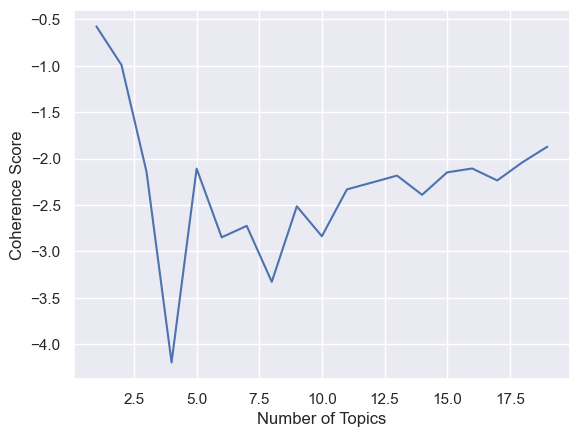

In [12]:
# Coherence score using C_umass:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts=retrievalHistoryReport['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


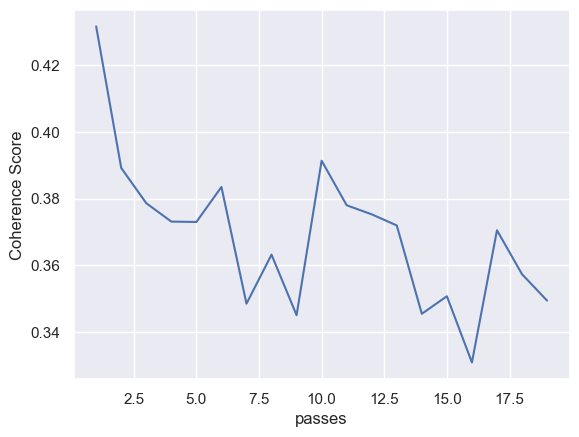

In [13]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=26, num_topics=i, workers = 4, passes=36)
   cm = CoherenceModel(model=lda_model, texts=retrievalHistoryReport['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('passes')
_=plt.ylabel('Coherence Score')
plt.show()